# Housekeeping

## Library imports

In [87]:
from click.formatting import iter_rows

if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

In [88]:
import pandas as pd

import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay, precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from colorama import Fore, Back, Style

import warnings

import matplotlib.pyplot as plt

## Settings

In [89]:
warnings.filterwarnings("ignore")
sklearn.set_config(transform_output="pandas")
print(Style.RESET_ALL)

## Data imports
Data was manually edited, to convert the mpa411.txt TSV format to a CSV format. Otherwise, Pandas was loading it as a single column, somehow. The first row, containing only "#mpa_vJun23_CHOCOPhlAnSGB_202403" was removed.

In [90]:
data = pd.read_csv('../data/raw/MAI3004_lucki_mpa411.csv')
metadata = pd.read_csv('../data/raw/MAI3004_lucki_metadata_safe.csv')
print(f"Data successfully imported. \n shape of data: {data.shape} \n Shape of metadata: {metadata.shape}")

assert data.shape == (6903, 932), "Data has the wrong shape. Check the CSV formatting."
assert metadata.shape == (930, 6), "Metadata has the wrong shape. Check the CSV formatting."

Data successfully imported. 
 shape of data: (6903, 932) 
 Shape of metadata: (930, 6)


## Function definitions
| Function Name | Description | Parameters |
|---------------|-------------|------------|


# Data preprocessing

## Merge data and metadata

In [91]:
sample_cols = [col for col in data.columns if col.startswith("mpa411_")]

sample_abundances = (
    data[['clade_name'] + sample_cols]
    .set_index('clade_name')
    .transpose()
    .rename_axis('original_sample_id')
    .reset_index()
    .rename(columns={'original_sample_id': 'sample_id'})
)

sample_abundances['sample_id'] = sample_abundances['sample_id'].str.removeprefix('mpa411_')

metadata_common = metadata[metadata['sample_id'].isin(sample_abundances['sample_id'])].copy()
merged_samples = metadata_common.merge(sample_abundances, on='sample_id', how='inner')

print(f"Metadata rows (original): {metadata.shape[0]}")
print(f"Metadata rows with matching samples: {metadata_common.shape[0]}")
print(f"Merged dataframe shape: {merged_samples.shape}")

Metadata rows (original): 930
Metadata rows with matching samples: 930
Merged dataframe shape: (930, 6909)


## Missing check

In [110]:
missing_table = (
    merged_samples.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(
        missing_percent=lambda df: (df["missing_count"] / merged_samples.shape[0] * 100).round(2)
    )
    .reset_index()
    .rename(columns={"index": "column"})
    .sort_values("missing_count", ascending=False)
    .query("missing_count != 0")
)

missing_table


,column,missing_count,missing_percent
4,age_group_at_sample,122,13.12


## Outlier check

## EDA

In [93]:
print(merged_samples.shape)
merged_samples.head()

(930, 6909)


,sample_id,family_id,sex,body_product,age_group_at_sample,year_of_birth,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,stool,1-2 weeks,2023,11.15024,88.849765,51.309655,0.002106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,stool,NaN,1995,13.65529,86.284502,4.551376,0.041143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,stool,1-2 weeks,2021,20.33656,79.663440,64.794124,10.664824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,stool,NaN,1978,11.30536,88.694643,11.944587,0.284914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,stool,4 weeks,2021,21.67587,78.324133,57.245464,18.558613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
#dataset overview
print("Number of samples:", len(merged_samples))
print("Number of unique children (family_id):", merged_samples["family_id"].nunique())
print("Number of columns (metadata + features):", merged_samples.shape[1])

Number of samples: 930
Number of unique children (family_id): 139
Number of columns (metadata + features): 6909


In [95]:
#samples per child
samples_per_child = merged_samples["family_id"].value_counts()
samples_per_child.describe()

count    139.000000
mean       6.690647
std        2.232335
min        1.000000
25%        5.500000
50%        7.000000
75%        8.000000
max       11.000000
Name: count, dtype: float64

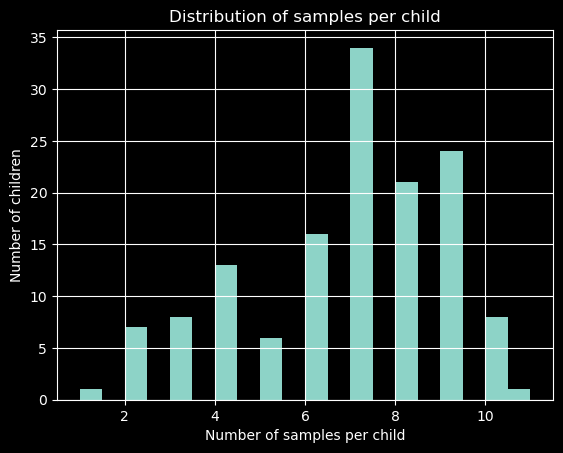

In [96]:
samples_per_child.hist(bins=20)
plt.xlabel("Number of samples per child")
plt.ylabel("Number of children")
plt.title("Distribution of samples per child")
plt.show()

In [97]:
#distribution of age groups
merged_samples["age_group_at_sample"].value_counts(dropna=False)

age_group_at_sample
NaN          122
8 weeks      105
4 months     103
5 months      96
9 months      92
6 months      88
1-2 weeks     84
11 months     83
4 weeks       82
14 months     75
Name: count, dtype: int64

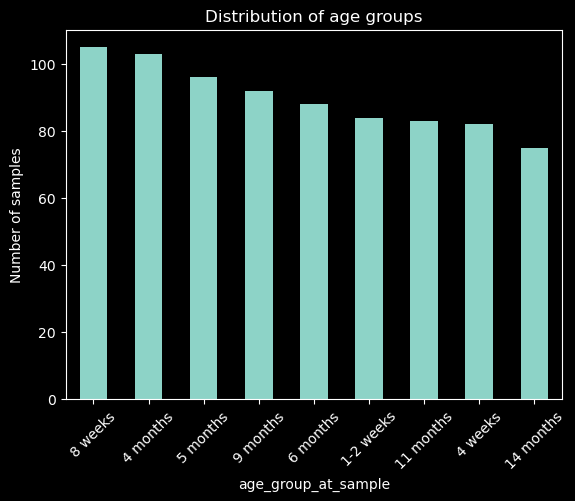

In [98]:
merged_samples["age_group_at_sample"].value_counts().plot(kind="bar")
plt.title("Distribution of age groups")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.show()

In [99]:
#dimensionality and sparsity of the microbiome feature matrix
metadata_cols = ["sample_id", "family_id", "sex", "body_product", "age_group_at_sample", "year_of_birth"]
feature_cols = [c for c in merged_samples.columns if c not in metadata_cols]

X = merged_samples[feature_cols]

print("Feature matrix shape:", X.shape)
print("Overall fraction of zeros:", (X == 0).mean().mean())

Feature matrix shape: (930, 6903)
Overall fraction of zeros: 0.9556136571445484


In [100]:
#number of observed taxa per sample
nonzero_per_sample = (X > 0).sum(axis=1)
nonzero_per_sample.describe()

count     930.000000
mean      306.398925
std       338.629879
min        46.000000
25%       127.000000
50%       181.000000
75%       282.000000
max      1821.000000
dtype: float64

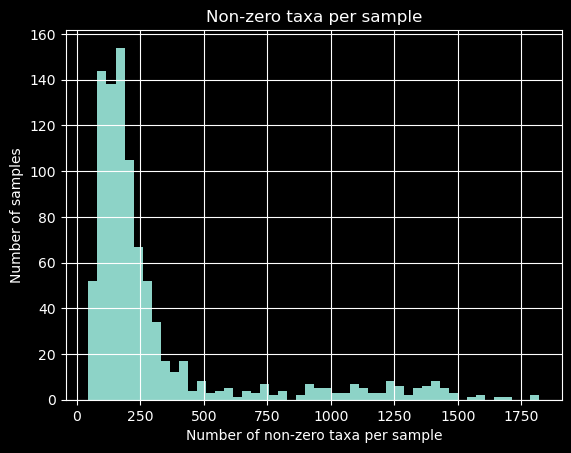

In [101]:
nonzero_per_sample.hist(bins=50)
plt.xlabel("Number of non-zero taxa per sample")
plt.ylabel("Number of samples")
plt.title("Non-zero taxa per sample")
plt.show()

In [102]:
#total abundance per sample (sanity check)
total_abundance = X.sum(axis=1)
total_abundance.describe()

count    930.000000
mean     704.546050
std       64.838116
min      337.616534
25%      676.683539
50%      715.251764
75%      749.225950
max      800.000170
dtype: float64

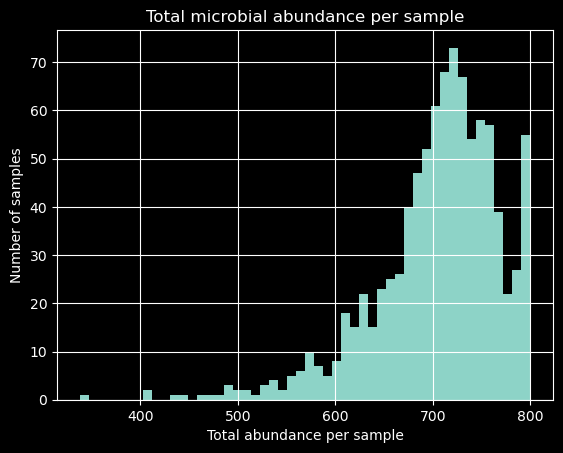

In [103]:
total_abundance.hist(bins=50)
plt.xlabel("Total abundance per sample")
plt.ylabel("Number of samples")
plt.title("Total microbial abundance per sample")
plt.show()

In [104]:
#distribution of feature prevalence
feature_prevalence = (X > 0).sum(axis=0)
feature_prevalence.describe()

count    6903.000000
mean       41.279299
std        96.983595
min         1.000000
25%         2.000000
50%         9.000000
75%        38.000000
max       930.000000
dtype: float64

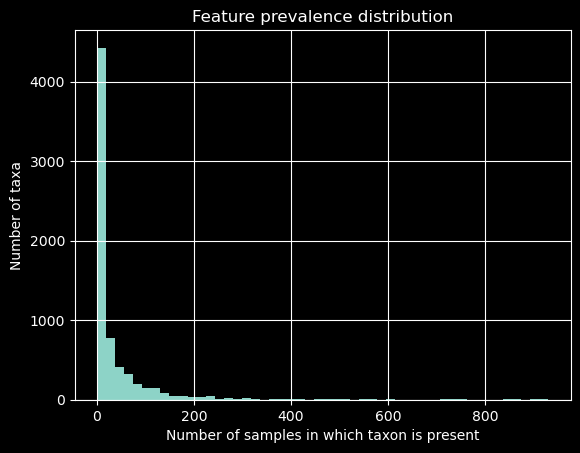

In [105]:
feature_prevalence.hist(bins=50)
plt.xlabel("Number of samples in which taxon is present")
plt.ylabel("Number of taxa")
plt.title("Feature prevalence distribution")
plt.show()

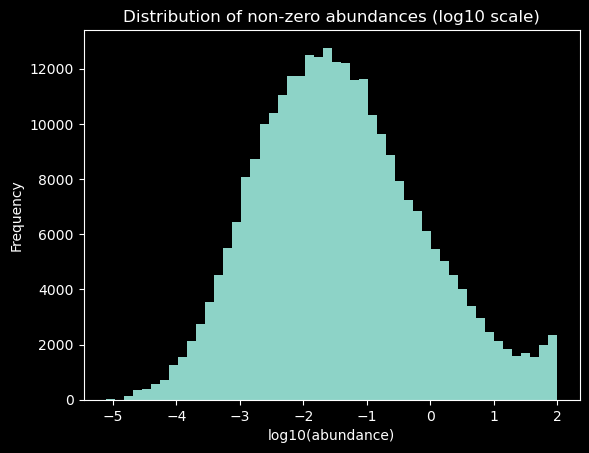

In [106]:
#distribution of non-zero abundances (log scale)
import numpy as np

nonzero_values = X.values[X.values > 0]
plt.hist(np.log10(nonzero_values), bins=50)
plt.xlabel("log10(abundance)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero abundances (log10 scale)")
plt.show()

In [107]:
#PCA visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use a subset of features for speed
prevalence = (X > 0).sum(axis=0)
top_features = prevalence.sort_values(ascending=False).head(500).index

X_sub = X[top_features]

# Scale features
X_scaled = StandardScaler().fit_transform(X_sub)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
age = merged_samples["age_group_at_sample"]

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=pd.factorize(age)[0], cmap="viridis", alpha=0.6)
plt.colorbar(label="Age group (encoded)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of samples colored by age group")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 800x600 with 0 Axes>

### Summary of EDA
The dataset consists of 930 longitudinal samples from 139 children and contains approximately 6900 microbiome features, making it a high-dimensional and highly sparse dataset. Each sample contains on average around 300 detected taxa, while the total abundance per sample is relatively stable, indication proper normalization. Most taxa are rare and occur only in a small number of samples, while a small subset is highly prevalent. The distribution of non-zero abundances follows a log-normal pattern, which is typical for microbiome data (Lutz et al., 2022). A PCA projection reveals a clear age-related gradient, indicating that microbiome composition changes gradually with age and that age-related structure is strongly embedded in the data.